### Neural Network Implementation Testing

This where we verified the neural network worked properly on two different datasets, the Iris dataset and a toy "make moons" toy dataset.

In [757]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import sys
import copy
import math
from sklearn.model_selection import train_test_split

In [758]:
class Layer:
    # essentially a container to hold stored values across layers in forward propogation
    def __init__(self, h_x = None, sigma_h_x = None):
        self.h_x = h_x
        self.sigma_h_x = sigma_h_x


class NeuralNetwork:
    
    def __init__(self, layers, nodes, activation, loss, learning_rate, batch_size, anneal):
        
        # number of hidden layers we are creating
        self.num_layers = layers
        
        # number of nodes at each layer
        self.nodes = self._create_nodes(nodes,layers)
        
        # activation function
        self.sigma = activation
                
        # loss function
        self.loss = loss
        
        # learning rate for stochastic gradient descent
        self.lr = learning_rate
        self.true_lr = learning_rate
        # batch size for stochastic gradient descent
        self.batch_size = batch_size

        # after fit, will contain a dictionary of weights for the layers
        self.weight_dict = None
        
        # store values for backwards propagation
        self.stored = None
        
        self.anneal = anneal

        
    def _create_nodes(self, nodes, layers):
        # if given a number, creates an array with layers amount of nodes
        # otherwise returns the array of nodes
        # in both cases increments by 1 to account for bias
        if isinstance(nodes, int):
            return [nodes]*(layers)
        
        else:
            if len(nodes) != self.num_layers:
                raise Exception("Node array length does not match number of layers")
            return nodes
        
    def _create_weights(self,  num_features):
        
        zero_weight = np.random.normal(scale=math.sqrt(2/num_features) ,size=(num_features,self.nodes[0]))

        self.weight_dict = {
            
            0: np.vstack((np.zeros(self.nodes[0]),zero_weight))
        }
        
        for i in range(1,self.num_layers):
            
            weight = np.random.normal(scale=math.sqrt(2/num_features) ,size=(self.nodes[i-1],self.nodes[i]))
            self.weight_dict[i] = np.vstack((np.zeros(self.nodes[i]), weight))
            
        weight = np.random.normal(scale=math.sqrt(2/num_features) ,size=(self.nodes[self.num_layers-1],1))
        self.weight_dict[self.num_layers] = np.vstack((np.zeros(1), weight))


    def _forward_propagation(self, X, y):
        # performs forward_propagation and stores appropriate values
        
        sigma_h_x = X
        self.stored = {}
        self.stored[-1] = Layer(None, sigma_h_x)
        
        for i in range(0,self.num_layers):
            sigma_h_x = np.hstack([np.ones(len(sigma_h_x ))[:, np.newaxis], sigma_h_x]) # adds a weight intercept to the front  
            h_x = sigma_h_x @ self.weight_dict[i] 
            sigma_h_x = self.sigma(h_x) 
            self.stored[i] = Layer(h_x, sigma_h_x)
            
        sigma_h_x = np.hstack([np.ones(len(sigma_h_x))[:, np.newaxis], sigma_h_x])
        z_sigma_h_x = sigma_h_x @ self.weight_dict[self.num_layers]
        self.stored[self.num_layers] = Layer(z_sigma_h_x)
        
        return np.sum(self.loss(z_sigma_h_x, y))/self.batch_size 

    def _backward_propagation(self, X,y):
        # updates the weights based on the stored values from forward propagation
        
        num_layers = self.num_layers
        expected = self.stored[self.num_layers].h_x #z(sigma(h2(sigma(h1(x)))))
        
        # dL/dz(z(sigma(h2(sigma(h1(x))))))
        J = self.loss(expected, y, derivative = True)
        
        old_weights = self.weight_dict[num_layers][1:,:] 
        old_bias = self.weight_dict[num_layers][0:1,:] 

        
        new_weights = old_weights - self.lr*(self.stored[num_layers-1].sigma_h_x.T @ J)
        new_bias = old_bias - (self.lr * (np.array([np.ones(J.shape[0])]) @ J))

        self.weight_dict[num_layers] = np.vstack((new_bias, new_weights))

        J = J @ old_weights.T
        
        for i in range(self.num_layers-1,-1,-1):
           
            J = J * self.sigma(self.stored[i].h_x, derivative = True) # activation layer derivative

            old_weights = self.weight_dict[i][1:,:] 
            old_bias = self.weight_dict[i][0:1,:] 

            new_weights = old_weights - self.lr*(self.stored[i-1].sigma_h_x.T @ J)
            new_bias = old_bias - (self.lr * (np.array([np.ones(J.shape[0])]) @ J))

            self.weight_dict[i] = np.vstack((new_bias, new_weights))
            
            J = J @ old_weights.T  # dense layer derivative       
            

    # want to backwards prop then feedforward
    def _stochastic_gradient_descent(self, X, y, X_val, y_val, diff, max_epochs, print_iter):
        
        no_improve = 0
        diff_num = 10
        
        num_batches = math.ceil(X.shape[0]/self.batch_size)
        
        avg_err_arr = [np.nan]*(max_epochs)
        avg_acc_arr = [np.nan]*(max_epochs)

        
        for i in range(0, max_epochs):
            
            indices = np.random.choice(X.shape[0], X.shape[0], replace=False)
            x_batch = X[indices]
            y_batch =y[indices]
            
            old_start = 0
            new_start = 0
            new_end = self.batch_size
            mini_err_arr = [np.nan]*num_batches
            mini_err_arr[0] = self._forward_propagation(x_batch[new_start:new_end],y_batch[new_start:new_end])

            for j in range(1,num_batches):
                old_start = new_start
                new_start = old_start + self.batch_size
                new_end = new_start+self.batch_size
                
                self._backward_propagation(x_batch[old_start:new_start], y_batch[old_start:new_start])
                mini_err_arr[j] = self._forward_propagation(x_batch[new_start:new_end],y_batch[new_start:new_end])
 
                if print_iter:
                    sys.stdout.write("\r" +  str(i) +"     " +str(j))
                    sys.stdout.flush()
                
            avg_err_arr[i] = np.mean(mini_err_arr)
            
                
            preds = self.predict(X_val)
            mse = np.mean((preds-y_val)**2)
            
            avg_acc_arr[i] = mse
            
            if i > 0 and (avg_acc_arr[i-1] - avg_acc_arr[i]) <= diff:
                no_improve +=1
                self.lr = self.lr * self.anneal
            else:
                no_improve = max(no_improve-1,0)
                
            if no_improve==5:
                return avg_err_arr[0:i+1], avg_acc_arr[0:i+1]
            
            if i!= max_epochs-1:
                 self._backward_propagation(x_batch[new_start:],y_batch[new_start:])
            
                
        return avg_err_arr, avg_acc_arr

    def fit(self, X,y, X_val, y_val, mse_diff = 0.000001, max_epochs = 10, print_iter = False):
        # X is either a numpy array or a dataframe without the target and intercept
        # y is either a pandas series or a 1d (potentially numpy) array
        # returns a list of the average loss for each iteration
        # if print iter is true, prints the current iteration (will be written on a single line, not multiple)
        self.lr = self.true_lr
        if isinstance(X, pd.DataFrame):
            new_x = X.to_numpy()
        else:
            new_x = copy.deepcopy(X)
            
        if isinstance(X_val, pd.DataFrame):
            new_x_val = X_val.to_numpy()
        else:
            new_x_val = copy.deepcopy(X_val)
            
        if isinstance(y, pd.Series):
            new_y = y.to_numpy()
        if len(y.shape) == 1:
            new_y = np.array([new_y]).T
        else:
            new_y = copy.deepcopy(y)
        
        if isinstance(y_val, pd.Series):
            new_y_val = y_val.to_numpy()
        if len(y_val.shape) == 1:
            new_y_val = np.array([new_y_val]).T
        else:
            new_y_val = copy.deepcopy(y_val)
            
        # generate the random weights for every layer in neural network
        self._create_weights(new_x.shape[1])
        
        vals = self._stochastic_gradient_descent(new_x,new_y,new_x_val, new_y_val, mse_diff, max_epochs, print_iter)
        

        return vals 
    def predict(self, X):
        
        sigma_h_x = X
        
        for i in range(0,self.num_layers):
            sigma_h_x = np.hstack([np.ones(len(sigma_h_x ))[:, np.newaxis], sigma_h_x ]) # adds a weight intercept  
            h_x = sigma_h_x @ self.weight_dict[i] 
            sigma_h_x = self.sigma(h_x) 
            
        sigma_h_x = np.hstack([np.ones(len(sigma_h_x))[:, np.newaxis], sigma_h_x ])
        z_sigma_h_x = sigma_h_x @ self.weight_dict[self.num_layers]
        return z_sigma_h_x.T[0]

# loss and activation function to use in 

def L2_loss(x,y, derivative = False):
    # assumes y is nx1 vector (n rows, 1 col)
    # returns an nx1 matrix
    if derivative:
        return x-y
    else:
        return 0.5*((x-y)**2)
        
def ReLU(X, derivative = False):

    if derivative:
        return np.greater(X, 0).astype(int)
    return np.maximum(X,0)      

### Testing on Iris Dataset

In [759]:
import sklearn.datasets
data = sklearn.datasets.load_iris()
df = pd.DataFrame(data.data, columns=data.feature_names)
df["target"] = df["sepal length (cm)"]
df = df.drop("sepal length (cm)", axis = 1)
df.head()

,sepal width (cm),petal length (cm),petal width (cm),target
0,3.5,1.4,0.2,5.1
1,3.0,1.4,0.2,4.9
2,3.2,1.3,0.2,4.7
3,3.1,1.5,0.2,4.6
4,3.6,1.4,0.2,5.0


In [760]:
X_train, X_test, y_train, y_test = train_test_split(df.drop("target",axis=1), df["target"], test_size=0.33, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.33, random_state=42)

layers = 3
nodes = 3
activation = ReLU
loss = L2_loss
learning_rate = 0.001
batch_size = 10
num_epochs = 200
anneal = 1

test_nn = NeuralNetwork(layers, nodes, activation, loss, learning_rate, batch_size, anneal = anneal)

errs,acc = test_nn.fit(X_train,y_train, X_val, y_val, mse_diff = 0.0001, max_epochs = num_epochs, print_iter = False)

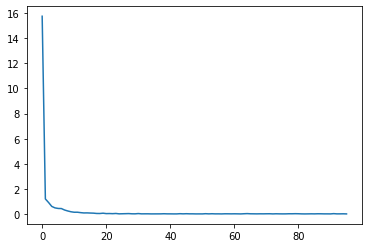

In [761]:
fig = plt.figure()
ax = plt.axes()

x = np.linspace(0, 10, 1000)
ax.plot([i for i in range(0,len(errs))], errs)

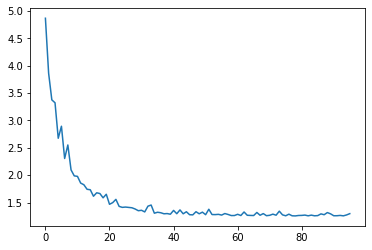

In [762]:
fig = plt.figure()
ax = plt.axes()

x = np.linspace(0, 10, 1000)
ax.plot([i for i in range(0,len(errs))], acc)

In [780]:
samp_size = 50
samp = df.sample(n=samp_size)


preds = test_nn.predict(X_test)
mse = np.mean((preds-y_test)**2)
mse

0.2500226787648579

### Testing on Moon Dataset

In [771]:
from sklearn.datasets import make_moons
import numpy as np
from matplotlib import pyplot as plt

X,y = make_moons(n_samples=10000,noise=0.1)
X = X.astype('float32')
y = y.astype('float32')
y = np.expand_dims(y,axis=-1)

In [811]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.33, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.33, random_state=42)

layers = 3
nodes = 4
activation = ReLU
loss = L2_loss
learning_rate = 0.00001
batch_size = 128
num_epochs = 200
anneal = 0.7

test_nn = NeuralNetwork(layers, nodes, activation, loss, learning_rate, batch_size, anneal = anneal)

errs,acc = test_nn.fit(X_train,y_train, X_val, y_val, mse_diff = 0.000001, max_epochs = num_epochs, print_iter = False)

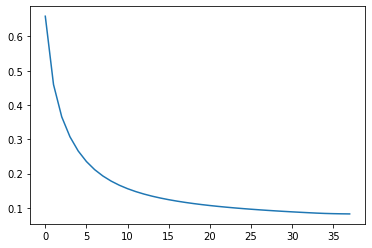

In [812]:
fig = plt.figure()
ax = plt.axes()

x = np.linspace(0, 10, 1000)
ax.plot([i for i in range(0,len(errs))], errs)

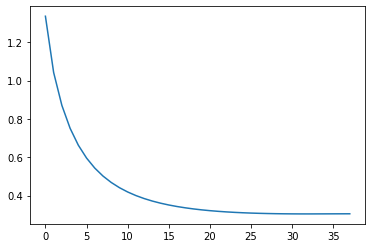

In [813]:
fig = plt.figure()
ax = plt.axes()

x = np.linspace(0, 10, 1000)
ax.plot([i for i in range(0,len(acc))], acc)

In [814]:
preds = test_nn.predict(X_test)
mse = np.sqrt(np.mean((preds-y_test)**2))
mse

0.5494309410369812